### Quantum Approximate Optimization Algorithm (QAOA)

The Quantum Approximate Optimization Algorithm (QAOA) is a variational algorithm designed to solve combinatorial optimization problems using quantum circuits. QAOA leverages alternating Hamiltonian evolutions to approximate the ground state of a given problem, where low energy states correspond to good solutions for the optimization task.

In QAOA, two types of Hamiltonians are alternately applied:

1. **Problem Hamiltonian, $ H_z $:** Encodes the problem's constraints and objective. Here, $ H_z = I \otimes Z + Z \otimes I $, which introduces interactions that depend on the \(Z\)-basis states of the qubits.
2. **Mixer Hamiltonian, $ H_{xx} $:** Creates transitions between basis states to explore the solution space. $ H_{xx} = X \otimes X $, which flips pairs of qubits, helping the system escape local minima.

These Hamiltonians are implemented as `AnalogGate` objects, which are applied sequentially to evolve the quantum state. The circuit starts with an initial state and alternates between $ H_z $ and $ H_{xx} $ gates for a series of steps, with random durations to represent the parameters. After a chosen number of steps, the qubits are measured, which ideally yields an approximate solution to the optimization problem.

In this example, we set up a **two-qubit system** and use the `AnalogCircuit` class to evolve the state under $ H_z $ and $ H_{xx} $ ten times. The `measure()` method at the end captures the resulting state, which corresponds to a candidate solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")

from oqd_core.interface.analog.operator import *
from oqd_core.interface.analog.operation import *
from oqd_core.backend.metric import *
from oqd_core.backend.task import Task, TaskArgsAnalog

from oqd_analog_emulator.qutip_backend import QutipBackend

In [2]:
X, Y, Z, I = PauliX(), PauliY(), PauliZ(), PauliI()

In [3]:
Hxx = X @ X
Hz = I @ Z + Z @ I

Gxx = AnalogGate(hamiltonian=Hxx)
Gz = AnalogGate(hamiltonian=Hz)

In [4]:
n = 2  # number of qubits
circuit = AnalogCircuit()
for _ in range(10):
    circuit.evolve(gate=Gz, duration=np.random.rand())
    circuit.evolve(gate=Gxx, duration=np.random.rand())
circuit.measure()

In [5]:
args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=4,
    metrics={
        "Z": Expectation(operator=((I @ Z + Z @ I) * -0.5)),
        "XX": Expectation(operator=(X @ X) * -1),
    },
    dt=1e-2,
)

task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()
results = backend.run(task=task)

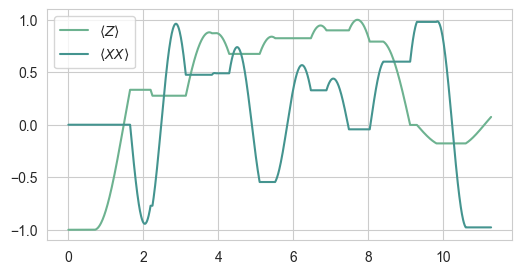

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=4)

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend();

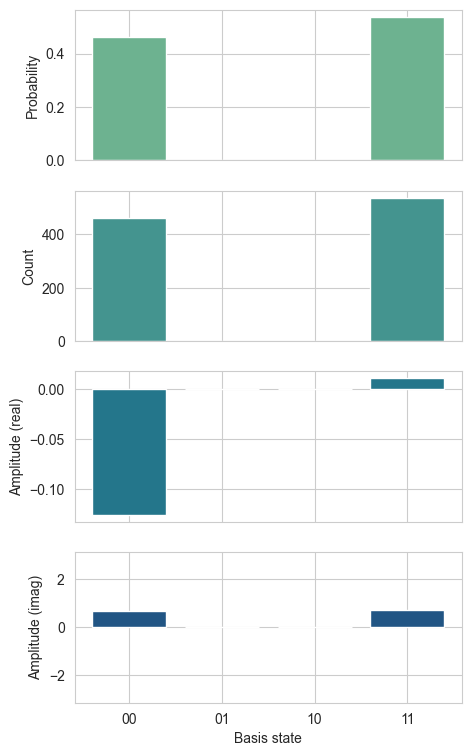

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")

ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")

ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi]);